In [ ]:
import os,sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from VARGG import running
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
import random
import numpy as np	
import torch
import pandas as pd
import scvelo as scv
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn import metrics

seed=1214

random.seed(seed)
np.random.seed(seed)                               	                                                                                                                                                                                                                                                             	
torch.manual_seed(seed) 	                                                                                                                                                                                                                                                                                                                                                                                                                                                           
torch.cuda.manual_seed(seed)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, De

In [ ]:
dataset = 'MERFISH_Bregma0.09'
save_path = "Result/"+str(dataset) 

In [ ]:
process = running(
	pre_epochs = 600, ####  choose the number of training
	epochs = 1200, #### choose the number of training
	use_gpu = True,
 	save_path=save_path)
###### Read data
adata=sc.read_h5ad("/data/Bregma0.09/raw/adata.h5ad")
adata = process._get_augment(adata, spatial_type="BallTree", use_morphological=False)

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0


Find adjacent spots of each spot:   0%|           [ time left: ? ]

Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]

Step 1: Augment molecule expression is Done!


In [ ]:
graph_dict = process._get_graph(adata.obsm["spatial"], distType = "KDTree")
data = process._data_process(adata, pca_n_comps = 144)

###### Training models
deepst_embed = process._fit(
		data = data,
		graph_dict = graph_dict,)
###### VARGG outputs
adata.obsm["VARGG_embed"] = deepst_embed
n_domains=14

# ###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
adata = process._get_cluster_data(adata, n_domains=n_domains, priori = True)


12.0000 neighbors per cell on average.
Step 2: Graph computing is Done!
Your task is in full swing, please wait
1741603103.9703062


VARGG trains an initial model: 100%|██████████ [ time left: 00:00 ]
VARGG trains a final model: |           [ time left: 00:00 ]    


Step 3: VARGG training has been Done!
Current memory usage：3.1320 GB
1741603258.3950198
Total time: 2.57 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data
Best resolution:  0.30999999999999994


In [ ]:
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
# filter out NA nodes
# calculate metric ARI and NMI
ARI = metrics.adjusted_rand_score(adata.obs['VARGG_refine_domain'], adata.obs['celltype'])
NMI=metrics.normalized_mutual_info_score(adata.obs['VARGG_refine_domain'], adata.obs['celltype'])
print(f"VARGG   ARI:{ARI},   NMI:{NMI}")

VARGG   ARI:0.2901425486428827,   NMI:0.43449207407593243


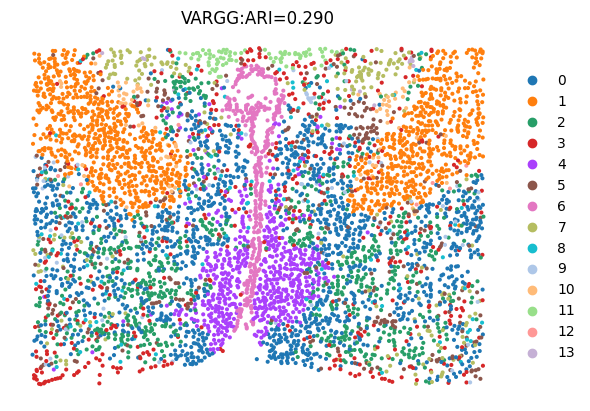

In [ ]:
sc.pl.embedding(adata, basis='spatial', color=['VARGG_refine_domain'], show=True, s=35,title=["VARGG:ARI=%.3f"%ARI], frameon=False)